In [40]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from requests import get
import math
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
import random

## Plan to make pseudoabsences:
### The general idea is to emulate the target-group background points method to generate pseudo-absences in single-species models (by using points from other species clearly separated from the populations of interest, rather than producing points randomly).

https://doi.org/10.1016/j.ecoinf.2024.102623 - recent overview of pseudoabsences, especially for multi-species deep learning

https://doi.org/10.1890/07-2153.1 - pseudoabsence and single species sample selection bias
 
- For each species, define the rectangular area within which the species is present (S).

- Then define a rectangular area that contains ALL data points (A).

- Assign absences for each species to points where other species are observed in the difference area D (A - S).

In [53]:
#Step 0: load training set
train=pd.read_csv('train_USA_FLspecies.csv').drop(['Unnamed: 0'],axis=1)
species=list(set(train['species']))

In [54]:
# Step 1: Define A
min_lon, max_lon = train['Lon'].min(), train['Lon'].max()
min_lat, max_lat = train['Lat'].min(), train['Lat'].max()
A = box(min_lon, min_lat, max_lon, max_lat)



In [57]:
#Step 2: Loop through the data to get pseudoabsences from D!
#note: for some species, there should be a sizeable amount of absence points thanks to this, perhaps for a couple that are widespread there might actually be few points?
lat_0=[]
lon_0=[]
cls_0=[]
species_0=[]
country_0=[]
state_0=[]
alt_0=[]
altz_0=[]
absences=[]

for s in tqdm(species):
    subset=train.loc[train['species']==s]
    min_lon, max_lon = subset['Lon'].min(), subset['Lon'].max()
    min_lat, max_lat = subset['Lat'].min(), subset['Lat'].max()
    S = box(min_lon, min_lat, max_lon, max_lat)
    D = A.difference(S)
    negset=train.loc[train['species']!=s]
    ids=negset.index.tolist()
    for i in ids:
        x=negset['Lon'][i]
        y=negset['Lat'][i]
        point = geometry.Point(x, y)
        
        if D.contains(point):
            if S.contains(point): #breaks if somehow a point ends up in the species' area at the same time as D
                print(f'BEEP BEEP, a point is in the wrong spot dummy! Species looked at: {s}')
                break
            #get data
            cls=negset['Cls'][i]
            state=negset['state'][i]
            alt=negset['Alt'][i]
            altz=negset['Alt_zone'][i]
            #define new row for absence data
            species_0.append(s)
            lat_0.append(y)
            lon_0.append(x)
            cls_0.append(cls)
            state_0.append(state)
            alt_0.append(alt)
            altz_0.append(altz)
            
#complete country and absence rows with minimal computing            
for i in range(len(species_0)):
    country_0.append('US')
    absences.append(0)

100%|██████████| 36/36 [01:00<00:00,  1.69s/it]


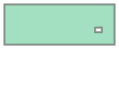

In [37]:
#OPTIONAL - code to play around with the geometry functions
subset=train.loc[train['species']==65987]
min_lon, max_lon = subset['Lon'].min(), subset['Lon'].max()
min_lat, max_lat = subset['Lat'].min(), subset['Lat'].max()
S = box(min_lon, min_lat, max_lon, max_lat)
D = A.difference(S) #creates the difference polygon, removing the area containing the species s


In [60]:
#Get some info from the new data
print(len(species_0)

469434

In [61]:
#save data
train_0dict={'Lat':lat_0,'Lon':lon_0,'Cls':cls_0,'species':species_0,'country_code':country_0,'state':state_0,'Alt':alt_0,'Alt_zone':altz_0,'presence':absences}
train_0=pd.DataFrame(train_0dict)

In [63]:
#concatenate presence and absence data
train_full=pd.concat([train,train_0])

In [67]:
#save to csv
train_0.to_csv('train_USA_FLspecies_pseudoabs.csv',index=False)
train_full.to_csv('train_USA_FLspecies_full.csv',index=False)

In [66]:
train_full

,Lat,Lon,Cls,species,country_code,state,Alt,Alt_zone,presence
0,25.634735,-80.340370,Am,41301,US,Florida,6.0,1,1
1,37.769390,-122.477516,Csb,41301,US,California,90.0,2,1
2,30.487162,-98.510986,Cfa,41301,US,Texas,356.0,3,1
3,31.403215,-111.242226,BSk,41301,US,Arizona,1090.0,5,1
4,29.761759,-95.398102,Cfa,41301,US,Texas,7.0,1,1
...,...,...,...,...,...,...,...,...,...
469429,41.859474,-87.827278,Dfa,38008,US,Illinois,194.0,3,0
469430,35.969742,-111.718010,Csb,38008,US,Arizona,1769.0,6,0
469431,29.366583,-95.983978,Cfa,38008,US,Texas,23.0,1,0
469432,45.245014,-84.086388,Dfb,38008,US,Michigan,256.0,3,0


In [65]:
#is the concatenated data of the correct length?
len(train_full)==(len(train)+len(train_0))

True